In [1]:
from scipy.optimize import curve_fit
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import functools
from loguru import logger
from GEN_Utils import FileHandling

logger.info('Import OK')

output_folder = 'results/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

2022-01-21 15:23:45,311 GEN_Utils.FileHandling: [INFO ]  Import ok
2022-01-21 15:23:45.313 | INFO     | __main__:<module>:13 - Import OK


In [2]:

def gauss(x, H, A, mean, sigma):
    return H + A * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))


def fit_gauss(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt


def plot_gauss(xdata, ydata):

    popt = fit_gauss(xdata, ydata)

    xfit = np.arange(np.min(xdata), np.max(xdata),
                     (np.max(xdata) - np.min(xdata))/1000)

    fig, ax = plt.subplots()
    plt.plot(xdata, ydata, 'ko', label='data')
    plt.plot(xfit, gauss(xfit, *popt), '--r', label='fit')
    ax.axvline(popt[2])
    plt.show()

    return popt


def peak_maker(peak_dict, x_range=(0, 50), precision=0.1, noise=0.05, visualise=False):
    x0, x1 = x_range
    peaks = []
    for peak, (H, A, mean, sigma) in peak_dict.items():
        peak_vals = pd.DataFrame([np.arange(x0, x1, precision), gauss(
            np.arange(x0, x1, precision), H=H, A=A, mean=mean, sigma=sigma)], index=['x', 'y']).T
        peak_vals['y'] = peak_vals['y'] + \
            np.random.uniform(0, noise, len(peak_vals))
        peaks.append(peak_vals)
    peaks = pd.concat(peaks).groupby('x').sum().reset_index()

    if visualise:
        sns.lineplot(
            data=peaks,
            x='x',
            y='y')
        plt.show()

    return peaks


def plot_peaks(dfs, labels, colors, separate=True, combined=False, max_val=None):
    for label, df_list in dfs.items():
        if separate:
            fig, axes = plt.subplots(
                1, len(df_list), figsize=(len(df_list)*6, 5), squeeze=False)
            for x, df in enumerate(df_list):
                ax = axes[0][x]
                sns.lineplot(
                    data=df,
                    x='x',
                    y='y',
                    color=colors[x],
                    ax=ax,
                )
                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.set_ylabel(ylabels[x])
                ax.set_xlabel('Fraction')
                if max_val:
                    ax.set_ylim(0, max_val)
            plt.savefig(f'{output_folder}panels_{label}.png')
            plt.show()

        if combined:
            fig, ax = plt.subplots(figsize=(6, 5))
            sns.lineplot(
                data=df_list[0],
                x='x',
                y='y',
                color=colors[0])
            plt.xlabel('Fraction')
            plt.ylabel(labels[0], color=colors[0])
            plt.yticks(color=colors[0])
            if max_val:
                ax.set_ylim(0, max_val)

            ax2 = ax.twinx()
            sns.lineplot(
                data=df_list[1],
                x='x',
                y='y',
                color=colors[1],
                linestyle='--',
                ax=ax2)
            if max_val:
                ax2.set_ylim(0, max_val)
            plt.ylabel(labels[1], color=colors[1], rotation=-90, va='bottom')
            plt.yticks(color=colors[1])
            plt.savefig(f'{output_folder}combined_{label}.png')
            plt.show()


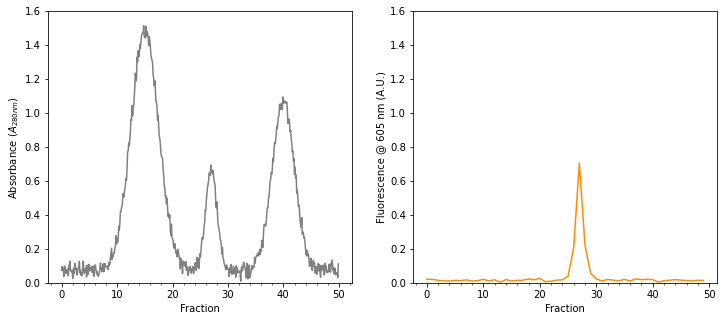

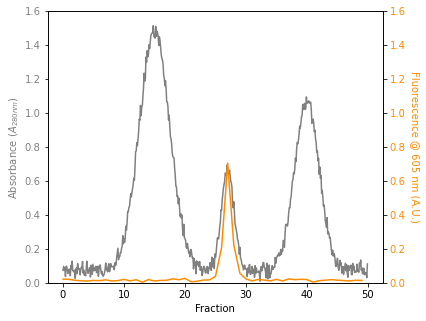

In [3]:
peaks = {
    1: [0, 1.4, 15, 2.5],
    2: [0, 0.6, 27, 1],
    3: [0, 1, 40, 2],
}
elution = peak_maker(peaks)
peaks = {
    3: [0, 0.1, 26.8, 0.6],
    4: [0, 0.4, 27, 0.5],
    5: [0, 0.2, 27.2, 1.0],
}
activity = peak_maker(peaks, precision=1, noise=0.01)

# Generate plots
dfs = {
    'example_4': [elution, activity],
}
ylabels = ['Absorbance ($A_{280 nm}$)', 'Fluorescence @ 605 nm (A.U.)']
colors = ['grey', 'darkorange']
plot_peaks(dfs, ylabels, colors, combined=True, max_val=1.6)
